Cluster Assignments and Descriptions:

Cluster 0: Vendors with low price changes and fewer price increases.
Vendors: voila, saveonfoods

Cluster 1: Vendors with moderate price changes and frequent price increases.
Vendors: metro, tandt, nofrills, walmart, loblaws

Cluster 2: Vendors with high price changes and very frequent price increases.
Vendors: galleria


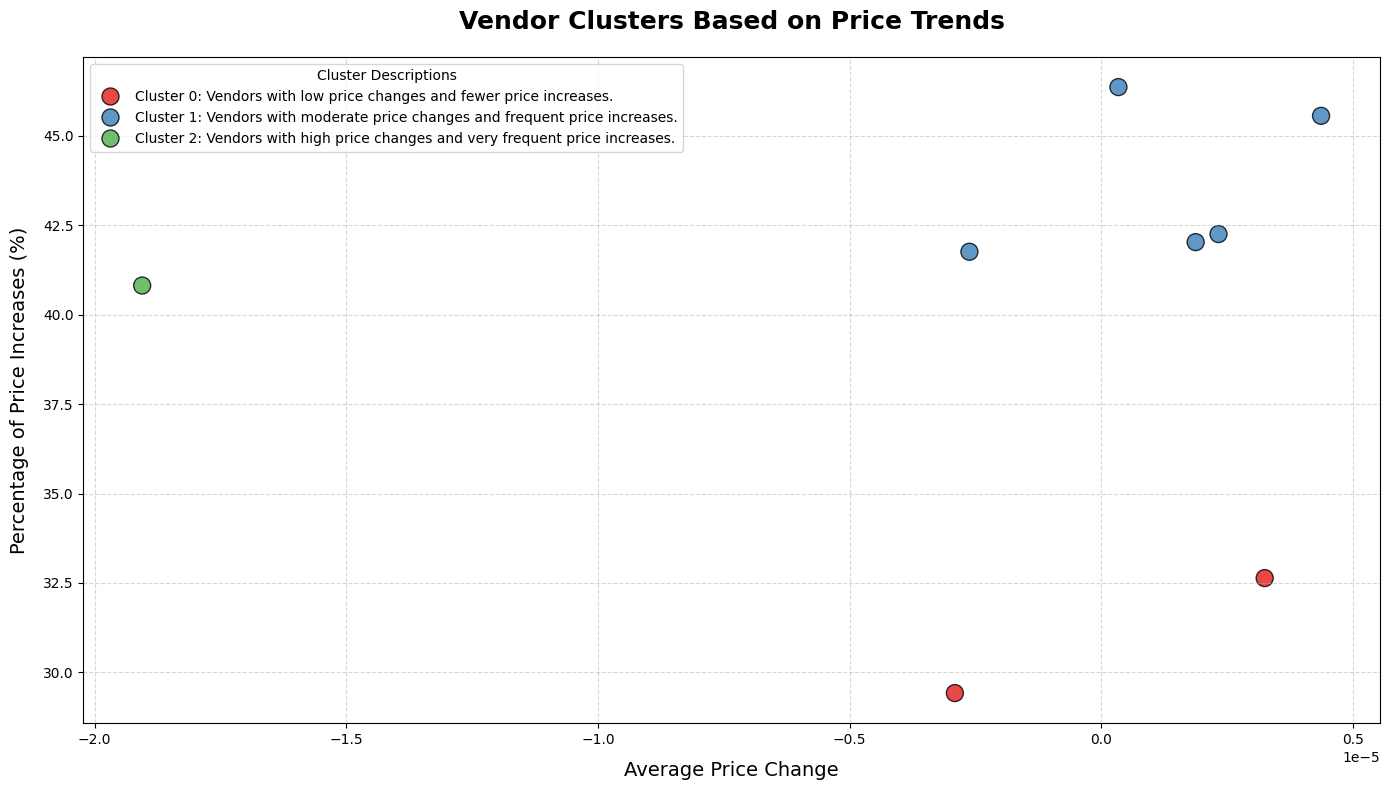

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, avg, count, sum, when, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
     

spark = SparkSession.builder \
    .appName("VendorPriceTrendAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
     

data = spark.read.csv("../data/cleaned_merged_data.csv", header=True, inferSchema=True)
data = data.dropna(subset=["vendor"])
data = data.withColumn("vendor", trim(lower(col("vendor"))))

valid_vendors = ['voila', 'galleria', 'loblaws', 'metro', 'nofrills', 'saveonfoods', 'tandt', 'walmart']

filtered_data = data.filter(col("vendor").isin(valid_vendors))

filtered_data = filtered_data.dropna(subset=["current_price", "nowtime"])

filtered_data = filtered_data.withColumn("nowtime", col("nowtime").cast("timestamp"))
     

window_spec = Window.partitionBy("vendor").orderBy("nowtime")
filtered_data = filtered_data.withColumn("previous_price", lag("current_price").over(window_spec))

filtered_data = filtered_data.withColumn(
    "price_change",
    when(col("previous_price").isNotNull(), col("current_price") - col("previous_price")).otherwise(0)
)

filtered_data = filtered_data.withColumn("price_increase", when(col("price_change") > 0, 1).otherwise(0))

# Aggregate vendor-level metrics
vendor_trends = filtered_data.groupBy("vendor").agg(
    avg("price_change").alias("average_price_change"),
    sum("price_increase").alias("total_price_increases"),
    count("price_change").alias("total_price_changes")
)

vendor_trends = vendor_trends.withColumn(
    "percentage_price_increase",
    (col("total_price_increases") / col("total_price_changes")) * 100
)
     

assembler = VectorAssembler(
    inputCols=["average_price_change", "percentage_price_increase"],
    outputCol="features"
)
vendor_trends = assembler.transform(vendor_trends)


scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(vendor_trends)
vendor_trends = scaler_model.transform(vendor_trends)


kmeans = KMeans(k=3, seed=42, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(vendor_trends)
vendor_trends = kmeans_model.transform(vendor_trends)

vendor_trends_pd = vendor_trends.select("vendor", "average_price_change", "percentage_price_increase", "cluster").toPandas()

cluster_descriptions = {
    0: "Vendors with low price changes and fewer price increases.",
    1: "Vendors with moderate price changes and frequent price increases.",
    2: "Vendors with high price changes and very frequent price increases."
}
     

print("Cluster Assignments and Descriptions:")
for cluster, description in cluster_descriptions.items():
    vendors_in_cluster = vendor_trends_pd[vendor_trends_pd["cluster"] == cluster]["vendor"].tolist()
    print(f"\nCluster {cluster}: {description}")
    print(f"Vendors: {', '.join(vendors_in_cluster)}")

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=vendor_trends_pd,
    x="average_price_change",
    y="percentage_price_increase",
    hue="cluster",
    palette="Set1",
    s=150,
    alpha=0.8,
    edgecolor="black"
)


handles, labels = scatter.get_legend_handles_labels()
new_labels = [f"Cluster {i}: {cluster_descriptions[i]}" for i in range(len(cluster_descriptions))]
plt.legend(handles=handles, labels=new_labels, title="Cluster Descriptions", fontsize=10, loc="upper left")
plt.title("Vendor Clusters Based on Price Trends", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Average Price Change", fontsize=14, labelpad=10)
plt.ylabel("Percentage of Price Increases (%)", fontsize=14, labelpad=10)
plt.grid(axis="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()